In [15]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install opencv-python

In [1]:
import cv2
import random
import json
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

In [2]:
import tqdm

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [6]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


In [7]:
import json

with open('train_segmentation/annotations.json') as f:
    annotations = json.load(f)

In [38]:
annotations.keys()

dict_keys(['categories', 'images', 'annotations'])

In [39]:
from random import shuffle

ani = annotations['images']
eng_ani = []
for ai in ani:
    if 'eng' in ai['file_name']:
        eng_ani.append(ai)
shuffle(ani)
ani = list(ani[:int(len(ani) / 1.5)] + eng_ani)
len(ani)

689

In [40]:
len(annotations['annotations'])

161700

In [41]:
#Пустой словарь для аннотаций валидации
annotations_val = {}
#Список категорий такой же как в train
annotations_val['categories'] = annotations['categories']

#Пустой словарь для аннотаций нового train
annotations_train = {}
#Список категорий такой же как в train
annotations_train['categories'] = annotations['categories']


#Положим в валидацию каждое 12 изображение из исходного train, а остальные - в новый train
annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%12==0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

#Положим в список аннотаций валидации только те аннотации, которые относятся к изображениям из валидации. 
#А в список аннотаций нового train - только те, которые относятся к нему
val_img_id = [i['id'] for i in annotations_val['images']]

train_img_id = [i['id'] for i in annotations_train['images']]


annotations_val['annotations'] = []
annotations_train['annotations'] = []
cnt = 0
for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')
        cnt += 1
cnt

0

In [42]:
total, eng = 0, 0
for ai in ani:
    if 'eng' in ai['file_name']:
        eng += 1
    total += 1
total, eng, eng/total

(689, 116, 0.1683599419448476)

In [8]:
with open('train_segmentation/annotations_val_15_2.json', 'w') as outfile:
    json.dump(annotations_val, outfile)
    
    
with open('train_segmentation/annotations_train_15_2.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

NameError: name 'annotations_val' is not defined

In [6]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("train_segmentation/annotations_{}_15_2.json".format(d),
    image_root= "gray",\
    dataset_name="my_dataset_"+d,extra_annotation_keys=['bbox_mode']))

In [7]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

In [8]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [11]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 854
Размер тестовой выборки (Картинки): 78


In [48]:
import os
from IPython.display import Image
@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [9]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

In [10]:
# Загружаем названия обучающией и тестовой выборок в настройки
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

# Часто имеет смысл сделать изображения чуть меньшего размера, чтобы 
# обучение происходило быстрее. Поэтому мы можем указать размер, до которого будем изменяться наименьшая 
# и наибольшая из сторон исходного изображения.
cfg.INPUT.MIN_SIZE_TRAIN = 3200
cfg.INPUT.MAX_SIZE_TRAIN = 2700

# Также мы должны сказать модели ниже какой вероятности определения она игнорирует результат. 
# То есть, если она найдет на картинке еду, но вероятность правильного определения ниже 0.5, 
# то она не будет нам сообщать, что она что-то нашла.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Также мы должны указать порядок каналов во входном изображении. Обратите внимание, что это Blue Green Red (BGR), 
# а не привычный RGB. Это особенности работы данной модели.
cfg.INPUT.FORMAT = 'BGR' 

# Для более быстрой загрузки данных в модель, мы делаем параллельную загрузку. Мы указываем параметр 4, 
cfg.DATALOADER.NUM_WORKERS = 4

# Следующий параметр задает количество изображений в батче, на котором 
# модель делает одну итерацию обучения (изменения весов).
cfg.SOLVER.IMS_PER_BATCH = 2

# Зададим также learning_rate
cfg.SOLVER.BASE_LR = 0.003

# Укажем модели, через сколько шагов обучения модели следует уменьшить learning rate
cfg.SOLVER.STEPS = (2000,)

# Фактор, на который уменьшается learning rate задается следующим выражением
cfg.SOLVER.GAMMA = 0.1

# Зададим общее число итераций обучения.
cfg.SOLVER.MAX_ITER = 2500

# Укажем количество классов в нашей выборке
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# Задаем через сколько  шагов обучения сохранять веса модели в файл. Этот файл мы сможем загрузить потом 
# для тестирования нашей обученной модели на новых данных.
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# И указываем название папки, куда сохранять чекпойнты модели и информацию о процессе обучения.
cfg.OUTPUT_DIR = './output_new1'

# Если вдруг такой папки нет, то создадим ее
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Если мы хотим удалить чекпойнты предыдущих моделей, то выполняем данную команду. 
#%rm output/*

In [11]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/03 22:50:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

2022-03-03 22:50:24.996591: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading

[03/03 22:50:28 d2.engine.train_loop]: Starting training from iteration 0
[03/03 22:51:09 d2.utils.events]:  eta: 1:19:49  iter: 19  total_loss: 2.853  loss_cls: 0.7294  loss_box_reg: 0.244  loss_mask: 0.6926  loss_rpn_cls: 0.8368  loss_rpn_loc: 0.3418  time: 1.9647  data_time: 0.0972  lr: 5.9943e-05  max_mem: 22282M
[03/03 22:51:12 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f69e5514e60> to CPU due to CUDA OOM
[03/03 22:51:49 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f69e5514e60> to CPU due to CUDA OOM
[03/03 22:52:22 d2.utils.events]:  eta: 1:19:45  iter: 39  total_loss: 2.231  loss_cls: 0.5842  loss_box_reg: 0.5355  loss_mask: 0.68  loss_rpn_cls: 0.1374  loss_rpn_loc: 0.2787  time: 2.8348  data_time: 0.0336  lr: 0.00011988  max_mem: 22282M
[03/03 22:52:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f69e5514e60> to CPU due to CUDA OOM
[03/03 22:53:17 d2.utils.events]:  eta: 1:19:06  iter

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [25]:
cfg.MODEL.WEIGHTS = "output3/model_0000999.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_val", )
#Изменение размера исходных изображений для тестового датасета
cfg.INPUT.MIN_SIZE_TEST= 1500
cfg.INPUT.MAX_SIZE_TEST = 2000
cfg.INPUT.FORMAT = 'BGR'

#ВАЖНО увеличить это значение (стандартное равно 100). Так как на листе тетради может быть довольно много слов
cfg.TEST.DETECTIONS_PER_IMAGE = 1000

predictor = DefaultPredictor(cfg)

In [20]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

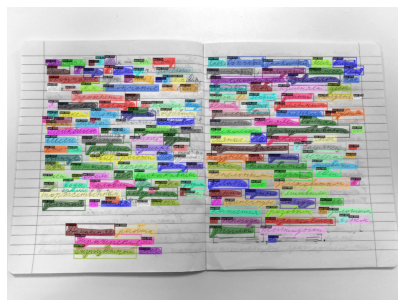

In [25]:
id_image_selected = 2
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

In [26]:
prediction = outputs['instances'].pred_masks.cpu().numpy()

In [40]:
prediction.shape

(57, 4032, 3024)

In [41]:
prediction[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

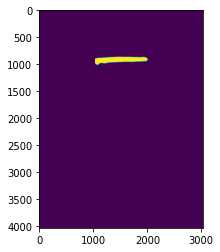

In [42]:
plt.imshow(prediction[0])

In [43]:
mask = np.add.reduce(prediction)

In [44]:
mask = mask > 0

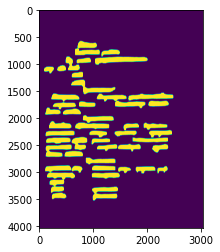

In [45]:
plt.imshow(mask)

Итак, нам нужно полуить такую маску для каждого изображения из валидационной выборки, а затем посчитать метрику F1-score.

In [15]:
#Подгрузим аннотации train
with open('train_segmentation/annotations_val_15_2.json') as f:
    annotations_val = json.load(f)

In [16]:
val_images = annotations_val['images']

In [17]:
val_predictions = {}

In [26]:
for val_img in tqdm.tqdm_notebook(val_images):
    file_name = val_img['file_name']
    img_path = os.path.join('train_segmentation/images/',file_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)
    prediction = outputs['instances'].pred_masks.cpu().numpy()
    mask = np.add.reduce(prediction)
    mask = mask > 0
    val_predictions[file_name] = mask

  0%|          | 0/78 [00:00<?, ?it/s]

In [50]:
val_predictions

{'1_0.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '1_12.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 '5_0.JPG': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [Fa

In [27]:
np.savez_compressed('val_pred3.npz',**val_predictions)

In [28]:
loaded_train = np.load('train_segmentation/binary.npz')

In [29]:
loaded_val_pred = np.load('val_pred3.npz')

In [30]:
def f1_loss(y_true, y_pred):
        
    
    tp = np.sum(y_true & y_pred)
    tn = np.sum(~y_true & ~y_pred)
    fp = np.sum(~y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* precision*recall / ( precision + recall + epsilon)

    return f1 

In [31]:
f1_scores = []
for key in tqdm.tqdm_notebook(loaded_val_pred.files):
    pred = loaded_val_pred[key].reshape(-1)
    true = loaded_train[key].reshape(-1)
    
    f1_img = f1_loss(true,pred)
    f1_scores.append(f1_img)

  0%|          | 0/78 [00:00<?, ?it/s]

In [32]:
np.mean(f1_scores)

0.8756077152050664

In [59]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.structures import Boxes, BoxMode 


In [60]:
def run(test_images_path,predictions_output_path):
    threshold = 0.5
    model_path = "./output/model_0002999.pth"
    
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) 
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.INPUT.MIN_SIZE_TEST= 300
    cfg.INPUT.MAX_SIZE_TEST = 300
    cfg.INPUT.FORMAT = 'BGR'
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    
    
    predictor = DefaultPredictor(cfg)
    results = {}
    
    
    for img in os.listdir(test_images_path):
        img_path = os.path.join(test_images_path,img)
        im = cv2.imread(img_path)
        outputs = predictor(im)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        mask = np.add.reduce(prediction)
        mask = mask > 0
        
        results[img] = mask  
    np.savez_compressed(predictions_output_path,**results)


In [ ]:
run('data/val/images','prediction.npz')

In [53]:
val_true = {}
for i in loaded_train.files:
    if i in val_predictions.keys():
        val_true[i] = loaded_train[i]

In [54]:
np.savez_compressed('val_true.npz',**val_true)

In [ ]:
!python evaluate.py --ref_path val_true.npz --pred_path val_pred.npz